# Disclaimer

This is a dirty hack to show what the `udkm1Dsim` is already capable of and what can be reused for a 3D magnetic scattering simulation.

# Setup

Do the installation (if not already done) and do the necessary imports

In [ ]:
%pip install udkm1Dsim

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

# Building a Structure

For simplicity I stick to the examples which are already included in the documentation, but of course we can easily change that to other materials, like Co/Pt multilayers, etc.

I also do not explain the steps of building the sample in to much details, since this is also well explained elsewhere

In [29]:
Fe = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg,
             atomic_form_factor_path='./Fe.cf')
# the magnetic form factor is already included as a default in the package and
# must not be explicitly loaded. Just the charge scattering data is by default
# from Henke or Chantler
Cr = ud.Atom('Cr')
Si = ud.Atom('Si')

In [3]:
density_Fe = 7874*u.kg/u.m**3

prop_Fe = {}
prop_Fe['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Fe['therm_cond'] = 80*u.W/(u.m *u.K)
prop_Fe['lin_therm_exp'] = 11.8e-6
prop_Fe['sound_vel'] = 4.910*u.nm/u.ps
prop_Fe['opt_ref_index'] = 2.9174+3.3545j

layer_Fe = ud.AmorphousLayer('Fe', 'Fe amorphous', 1*u.nm,
                             density_Fe, atom=Fe, **prop_Fe)

In [4]:
density_Cr = 7140*u.kg/u.m**3

prop_Cr = {}
prop_Cr['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Cr['therm_cond'] = 94*u.W/(u.m*u.K)
prop_Cr['lin_therm_exp'] = 6.2e-6
prop_Cr['sound_vel'] = 5.940*u.nm/u.ps
prop_Cr['opt_ref_index'] = 3.1612+3.4606j

layer_Cr = ud.AmorphousLayer('Cr', "Cr amorphous", 1*u.nm, density_Cr, atom=Cr, **prop_Cr)

In [5]:
density_Si = 2336*u.kg/u.m**3

prop_Si = {}
prop_Si['heat_capacity'] = 703*u.J/u.kg/u.K
prop_Si['therm_cond'] = 150*u.W/(u.m*u.K)
prop_Si['lin_therm_exp'] = 2.6e-6
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", 1*u.nm, density_Si, atom=Si, **prop_Si)

In [6]:
S = ud.Structure('Fe/Cr Super Lattice')

# create a sub-structure
DL = ud.Structure('Two Fe/Cr Double Layers')
DL.add_sub_structure(layer_Fe, 1)
DL.add_sub_structure(layer_Cr, 1)

S.add_sub_structure(DL, 30)
S.add_sub_structure(layer_Fe, 10)
S.add_sub_structure(layer_Si, 200)

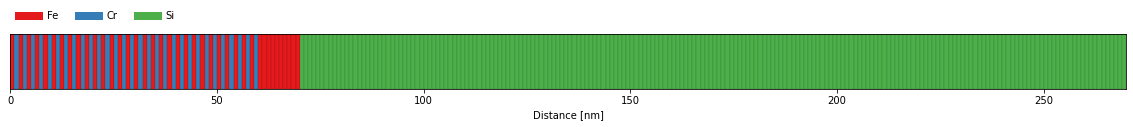

In [7]:
S.visualize()

# 3D spin map

With the 1D structure being build, we could now do some subsequent simulations, such as an $N$-temperature model, coherent phonon dynamics, a microscopic 3TM (Koopmans et al.), and I am also collaborating to implement Landau-Lifschitz-Bloch here.

But since everything is still in 1D it will be only partly of help for us.
Instead one could write a bridge, e.g. to `ubermag` in order to simulate some 3D spin profiles for some additionally given $x$- and $y$-coordinates including of course all the additional parameters, which are needed for this.

Lets pretend now, that this bridge does alread exist and we get a 3D map of spins, even for different delays in time.
This delay axis can of course also be used to sweep any other parameter, e.g. in a fitting routine.

For now the `udkm1Dsim` accepts such `magnetization_maps` having three dimentions:
1. dimension - delay time
2. dimension - depth $z$ of the sample
3. dimension - magnetization vector, being actually a vector $(3 \times 1)$

The code is currently `parallelized` for the first dimension since differnt delays do not depend on each other.
The second dimension is a also a `for`-loop traversing the structure in $z$-direction from top to bottom.
For every layer the actual reflection and transmission matrices are then calculated for a given magnetization vector and for a range of incidence angles $\vartheta$ and photon energies $E$.
This last step es actually `vectorized` and performes pretty well.

I would now suggest to add the two more lateral dimensions as two more outer loops, which can also be parallized similar to the delay.
1. dimension - delay time
2. dimension - depth $x$ of the sample
3. dimension - depth $y$ of the sample
4. dimension - depth $z$ of the sample
5. dimension - magnetization vector, being actually a vector $(3 \times 1)$

I do now create such a magnetization map for only one delay, and with a constant magnetization for all layers at every $x-y$ position.
The magnetization vector is defined by a magnitude, `phi` and `gamma` angle following the definition by the `Dyna` code:

In [17]:
delays = [0]
xs = np.linspace(0, 100, 10)
ys = np.linspace(0, 100, 10)

magnetization_map = np.zeros([len(delays),
                              len(xs),
                              len(ys),
                              S.get_number_of_layers(), # z
                              3])

# get a list of all layers in the 1D stack along z
handles = S.get_layer_vectors()[2]

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        for k, handle in enumerate(handles):
            if handle.id in ['Fe']:
                magnetization_map[:, i, j, k, 0] = 1 # magnitude
                magnetization_map[:, i, j, k, 1] = 0 # phi angle
                magnetization_map[:, i, j, k, 2] = 0 # gamma angle

# Dynamical magnetic x-ray scattering

With our fancy 3D spin map in place, we can now do the calculation of the reflection and transmisison matrices at every $x-y$ position.
I do that now only for a fixed angle and a fixed energy.
The also directly returns the result for parallel and antiparallel alignment of $\vec{k}$  and $\vec{M}$ - which has the suffix `_phi`.
Right now I am already calculating the final reflectivity for given incoming and outgoing polarizations.
But of course one can also return the preceding $4 \times 4$ matrices.

In [27]:
dyn_mag = ud.XrayDynMag(S, True)
dyn_mag.disp_messages = False
dyn_mag.save_data = False
dyn_mag.progress_bar = False
dyn_mag.set_polarization(1, 0)

dyn_mag.energy = np.r_[708]*u.eV  # set two photon energies
dyn_mag.theta = np.r_[10]*u.deg  # qz range

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


In [28]:
results = np.zeros([len(delays),
                    len(dyn_mag.energy),
                    len(dyn_mag.theta),
                    len(xs),
                    len(ys)
                   ])

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        xy_mag_map = magnetization_map[:, i, j, :, :]

        R_seq, R_seq_phi, _, _ = dyn_mag.inhomogeneous_reflectivity(
            magnetization_map=xy_mag_map
        )
        results[:, :, :, i, j] = R_seq

Thats actually it :)